# Bayesian Statistics + Regression

### Authors:
- Zdenek Lapes (xlapes02) [lapes.zdenek@gmail.com](mailto:lapes.zdenek@gmail.com)

# Import Packages

In [45]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.stats.outliers_influence import OLSInfluence

# Setup basic configuration + define helper functions

In [46]:
def write_to_file(file_name, content):
    with open(file_name, 'w') as f:
        f.write(content)


# Create directory for output files
Path('tmp/out').mkdir(parents=True, exist_ok=True)

# Set dark theme
# plt.style.use('dark_background')

# Set grid thickness
plt.rcParams['grid.linewidth'] = 0.3

# Load Data from Excel file

In [47]:
excel_file = pd.ExcelFile("Projekt-2_Data.xlsx")
df_uloha_1: pd.DataFrame = excel_file.parse(excel_file.sheet_names[0])
df_uloha_2 = excel_file.parse(excel_file.sheet_names[1])
data = {
    '1': df_uloha_1,
    '1_a': df_uloha_1['uloha_1 a)'],
    '1_b_prior': df_uloha_1['uloha_1 b)_prior'],
    '1_g': df_uloha_1['skupina'],
    '1_b_observation': df_uloha_1['uloha_1 b)_pozorování'],
    '2': df_uloha_2,
    '2_os': df_uloha_2['OSType'],
    '2_as': df_uloha_2['ActiveUsers'],
    '2_ip': df_uloha_2['InteractingPct'],
    '2_sp': df_uloha_2['ScrollingPct'],
    '2_p': df_uloha_2['Ping [ms]'],
}
# data

/Users/zlapik/.pyenv/versions/3.10.13/lib/python3.10/xml/etree/ElementTree.py:1651: ResourceWarning: unclosed file <_io.BufferedReader name='Projekt-2_Data.xlsx'>
  return self.target.start(tag, attrib)


# TASK 1 - Bayesian estimates

## TASK 1.a - Conjugate a priori and a posteriori distributions, predictive distribution [2 points]

### Clean data
- Remove outliers
- Remove nan values
- Remove +-inf values
- Remove values with Z-score > 3
- Remove values with Z-score < -3

In [48]:
df_uloha_1 = data['1_a']

# Extract observed data
observed_data = df_uloha_1.values

# Remove nan or +-inf values
observed_data = observed_data[~np.isnan(observed_data)]

# Calculate Z-scores
z_scores = stats.zscore(observed_data, nan_policy='raise')

# Define a threshold for outliers (e.g., 3 standard deviations)
threshold = 3

# Filter out rows with Z-scores beyond the threshold
filtered_data = observed_data[(np.abs(z_scores) < threshold)]
filtered_data

array([2., 2., 1., 3., 0., 1., 1., 3., 2., 2., 3., 1., 5., 3., 1., 1., 2.,
       1., 1., 1., 2., 3., 2., 0., 3., 1., 2., 1., 5., 1., 0., 0., 2., 1.,
       1., 0., 0., 1., 3., 1., 0., 1., 2., 0., 1., 3., 0., 1., 1., 4., 1.,
       2., 1., 1., 2., 4., 2., 2., 3., 4., 4., 4., 0., 2., 0., 0., 3., 5.,
       1., 2., 1., 0., 1., 1., 4., 1., 1., 3., 0., 1., 2., 2., 2., 3., 1.,
       2., 2., 2., 1., 2., 2., 1., 0., 1., 1., 3., 0., 3., 1., 1.])

### TASK 1.a.1 - Plot the a priori and aposteriori densities of the Poisson distribution $\lambda$ in one figure.

In [49]:
alpha_prior = 10  # connection count
beta_prior = 5  # time within the connection count (alpha_prior) was observed
lambda_expert = alpha_prior / beta_prior  # expert's estimate of the connection count

In [50]:
alpha_posterior = alpha_prior + np.sum(filtered_data)
beta_posterior = beta_prior + len(filtered_data)

In [51]:
x_prior = np.linspace(0, np.max(filtered_data), 1000)
y_prior = stats.gamma.pdf(x_prior, alpha_prior, scale=1 / beta_prior)

In [52]:
x_posterior = np.linspace(0, np.max(filtered_data), 1000)
y_posterior = stats.gamma.pdf(x_posterior, alpha_posterior, scale=1 / beta_posterior)

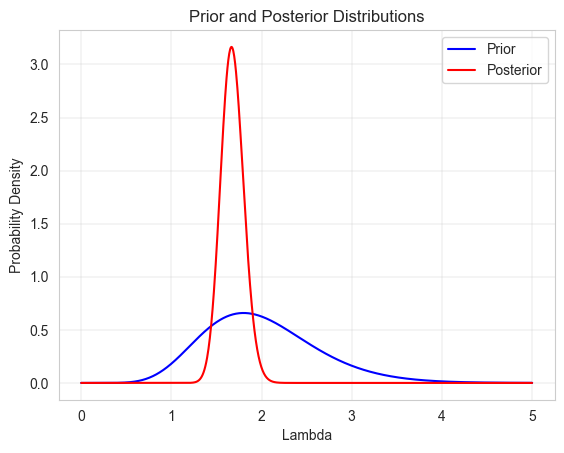

In [53]:
plt.plot(x_prior, y_prior, label='Prior', color='blue')
plt.plot(x_posterior, y_posterior, label='Posterior', color='red')
plt.title('Prior and Posterior Distributions')
plt.xlabel('Lambda')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

### TASK 1.a.2 - Plot the a priori and aposteriori predictive densities of observations $x$ over one time interval in one figure.

In [54]:
x_prior_interval = range(0, 6)  # 0 to 5 connections, because nbinom is discrete
y_prior_interval = stats.nbinom.pmf(x_prior_interval, alpha_prior, beta_prior / (1 + beta_prior))

In [55]:
x_posterior_interval = range(0, 6)  # 0 to 5 connections, because nbinom is discrete
y_posterior_interval = stats.nbinom.pmf(x_posterior_interval, alpha_posterior, beta_posterior / (1 + beta_posterior))

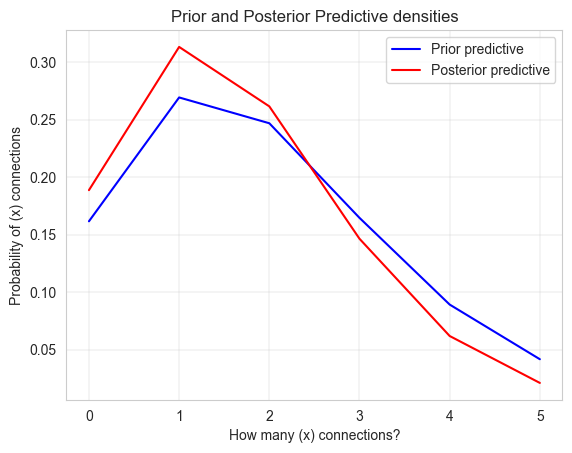

In [56]:
plt.plot(x_prior_interval, y_prior_interval, label='Prior predictive', color='blue')
plt.plot(x_posterior_interval, y_posterior_interval, label='Posterior predictive', color='red')
plt.title('Prior and Posterior Predictive densities')
plt.xlabel('How many (x) connections?')
plt.ylabel('Probability of (x) connections')
plt.legend()
plt.show()

### TASK 1.a.3 - Construct a 95% confidence interval for the parameter $\lambda$ from the a priori and aposteriori distribution and compare them.

In [57]:
prior_ci = stats.gamma.interval(0.95, alpha_prior, scale=1 / beta_prior)
posterior_ci = stats.gamma.interval(0.95, alpha_posterior, scale=1 / beta_posterior)
print(f"Prior 95% CI: ({prior_ci[0]:.5f}, {prior_ci[1]:.5f})")
print(f"Posterior 95% CI: ({posterior_ci[0]:.5f}, {posterior_ci[1]:.5f})")

Prior 95% CI: (0.95908, 3.41696)
Posterior 95% CI: (1.43769, 1.93272)


### TASK 1.a.4 - Choose two aposteriori point estimates of the parameter $\lambda$, compare and comment on them their selection.

In [58]:
posterior_mean = alpha_posterior / beta_posterior
posterior_mode = (alpha_posterior - 1) / beta_posterior
print(f"Aposteriori mean: {posterior_mean:.5f}")
print(f"Aposteriori mode: {posterior_mode:.5f}")

Aposteriori mean: 1.67619
Aposteriori mode: 1.66667


### TASK 1.a.5 - Choose one a priori and one a posteriori point estimate of the number of observations and compare them.

In [59]:
mu_prior = alpha_prior / beta_prior
mu_posterior = alpha_posterior / beta_posterior
print(f"Prior estimate: {mu_prior:.5f}")
print(f"Posterior estimate: {mu_posterior:.5f}")

Prior estimate: 2.00000
Posterior estimate: 1.67619


## TASK 1.b - Approximation by discrete distribution [2 points]

In [60]:
mu = 3
sigma = np.sqrt(1)
a = 1

### Prepare data fot TASK 1.

In [61]:
# Cleaned data
df_uloha_1_b = {
    'prior_data': data['1_b_prior'][~np.isnan(data['1_b_prior'])],
    'observed_data': data['1_b_observation'][~np.isnan(data['1_b_observation'])],
    'group_column': data['1_g'][~np.isnan(data['1_g'])]
}
observed_data = df_uloha_1_b['observed_data']

### TASK 1.b.1: Plot prior, posterior, and likelihood functions

In [62]:
bins_count = 50

# Get max value for each group
all_data_max = data['1'].groupby('skupina')['uloha_1 b)_prior'].max()

bin_width = (all_data_max.max() - all_data_max.min()) / bins_count  # Get bin width
bins = np.arange(all_data_max.min(), all_data_max.max(), bin_width)  # Bin values

bin_height, bin_edges = np.histogram(all_data_max, bins=bins_count)
bin_height_normalized = bin_height / np.sum(bin_height)

# Plot bins
# plt.bar(x=bins, height=bin_height_normalized, width=bin_width, color='blue', alpha=0.7)
# plt.show()

In [63]:
# Get center of each bin
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

def likelyhood_func(observed_data, b):
    """
    Calculate likelyhood function
    :param observed_data: 
    :param b: 
    :return: 
    """
    a_truncnorm = (a - mu) / sigma
    b_truncnorm = (b - mu) / sigma
    pdf = stats.truncnorm.pdf(observed_data, a=a_truncnorm, b=b_truncnorm, loc=mu, scale=sigma)
    return pdf

# Calculate likelyhood function for each bin
likelihood = [likelyhood_func(observed_data, b_center) for b_center in bin_centers]

# Calculate product of all likelyhoods
likelihood = np.prod(likelihood, axis=1)

# Normalize likelyhood
likelihood_normalized = likelihood / np.sum(likelihood)

# Plot likelyhood
# plt.bar(x=bins, height=likelihood_normalized, width=bin_width, edgecolor='black', color='red', label='Likelyhood', alpha=0.7)
# plt.show()

In [64]:
# Calculate posterior
posterior_probs = likelihood * bin_height_normalized
posterior_probs_normalized = posterior_probs / np.sum(posterior_probs)

# plt.bar(bin_centers, posterior_probs_normalized, width=bin_width, edgecolor='black', color='green', label='Aposteriórne rozdelenie', alpha=0.7)
# plt.show()

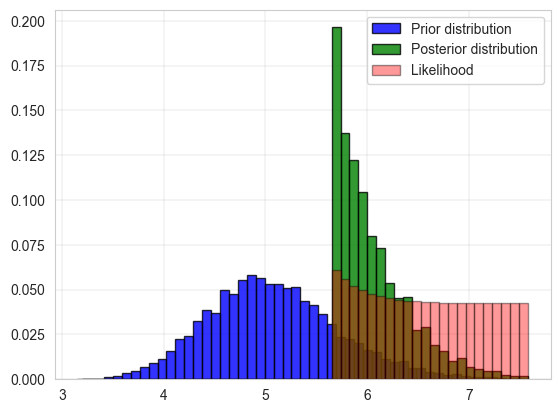

In [65]:
# Plot all together: prior, likelyhood, posterior
plt.bar(x=bins, height=bin_height_normalized, width=bin_width, color='blue', alpha=0.8, edgecolor='black', label='Prior distribution')
plt.bar(bin_centers, posterior_probs_normalized, width=bin_width, edgecolor='black', color='green', label='Posterior distribution', alpha=0.8)
plt.bar(bin_centers, likelihood_normalized, width=bin_width, edgecolor='black', color='red', label='Likelihood', alpha=0.4)
plt.legend()
plt.show()

### TASK 1.b.2. From the aposteriori density, determine the 95% confidence interval (confidence interval) for the parameter 𝑏.

In [66]:
# Calculate 95% confidence interval
cumulative_posterior = np.cumsum(posterior_probs_normalized)
lower_bound = bin_centers[np.argmax(cumulative_posterior >= 0.025)]
upper_bound = bin_centers[np.argmin(cumulative_posterior <= 0.975)]
print(f'95% Confidence Interval for Parameter b: {lower_bound:.5f}, {upper_bound:.5f}')

95% Confidence Interval for Parameter b: 5.69371, 7.00891


### TASK 1.b.3. Choose two point estimates of $b$ and calculate them.

In [67]:
# Calculate point estimates
mean = np.sum(bin_centers * posterior_probs_normalized)
median = bin_centers[np.argmax(posterior_probs_normalized)]
print(f'First point estimate: {mean:.5f}')
print(f'Second point estimate: {median:.5f}')

First point estimate: 6.05277
Second point estimate: 5.69371


# TASK 2 - Regression - 8. points

## TASK 2.1. Use backward elimination to determine the appropriate regression model. Consider the default "full" model to be the full quadratic model (all second order interactions and all squares that make sense). [4. points] 

### Learn more about data, before we start

In [68]:
# Load data
df_uloha_2 = data['2']

# Print data info to learn more about data
print(df_uloha_2.head())
print()
print(df_uloha_2.describe())

    OSType  ActiveUsers  InteractingPct  ScrollingPct  Ping [ms]
0      iOS         4113          0.8283        0.1717         47
1      iOS         7549          0.3461        0.6539         46
2  Windows         8855          0.2178        0.7822         55
3  Android         8870          0.0794        0.9206         56
4    MacOS         9559          0.7282        0.2718         76

       ActiveUsers  InteractingPct  ScrollingPct   Ping [ms]
count   502.000000      502.000000    502.000000  502.000000
mean   5485.830677        0.488613      0.511387   50.545817
std    2548.935679        0.296000      0.296000   14.797937
min     153.000000        0.000500      0.001400   11.000000
25%    3357.500000        0.229300      0.257525   40.000000
50%    5456.000000        0.482950      0.517050   52.000000
75%    7461.500000        0.742475      0.770700   60.000000
max    9953.000000        0.998600      0.999500   90.000000


### Visualize data using matrix plot

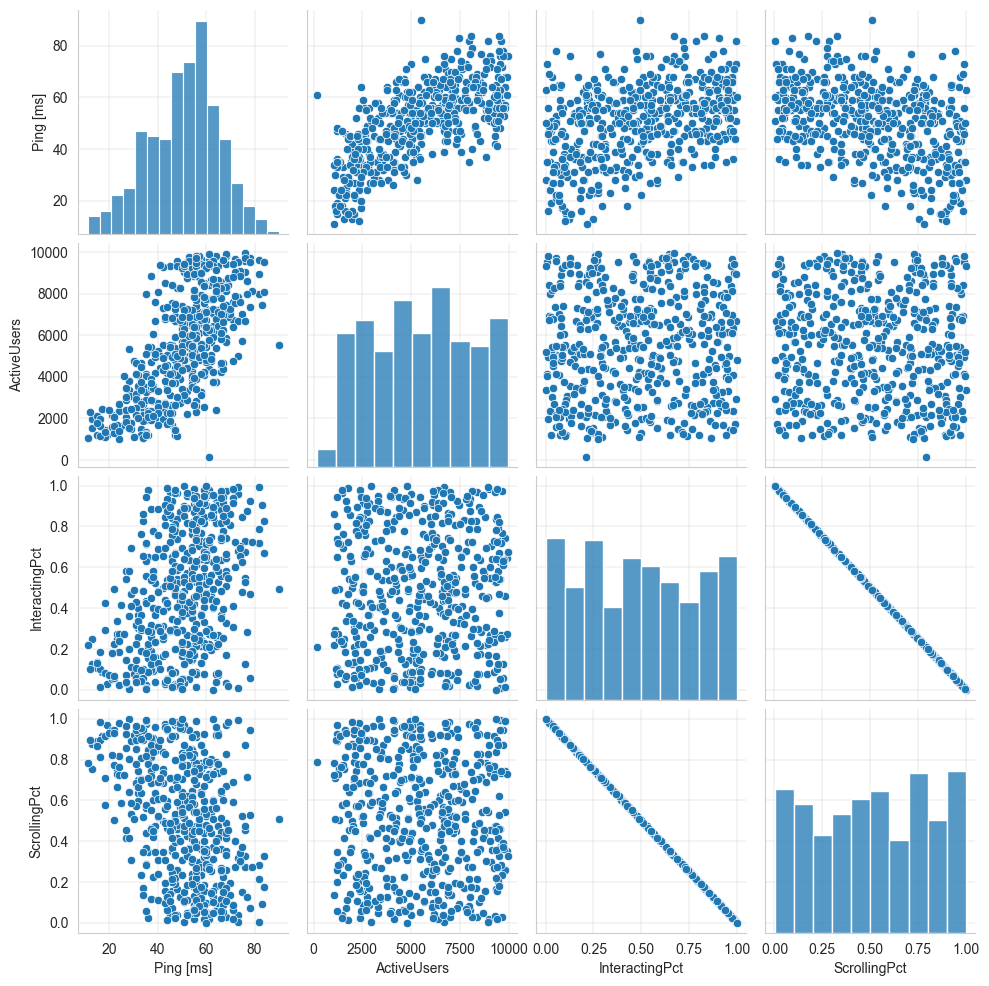

In [69]:
# Visualize data
ax = sns.pairplot(df_uloha_2[['Ping [ms]', 'ActiveUsers', 'InteractingPct', 'ScrollingPct']])
plt.show()

Based on the correlation matrix, we can see that there is a high correlation between InteractingPct and ScrollingPct. Therefore we can remove one of them.

I choose to remove __ScrollingPct__

In [70]:
# Remove correlated parameters
X = pd.DataFrame({
    'ActiveUsers': df_uloha_2.loc[:, 'ActiveUsers'],
    'InteractingPct': df_uloha_2.loc[:, 'InteractingPct'],
    'ScrollingPct': df_uloha_2.loc[:, 'ScrollingPct'],
    "Windows": df_uloha_2['OSType'].apply(lambda x: 1 if x == 'Windows' else 0),
    "iOS": df_uloha_2['OSType'].apply(lambda x: 1 if x == 'iOS' else 0),
    "MacOS": df_uloha_2['OSType'].apply(lambda x: 1 if x == 'MacOS' else 0),
    "Android": df_uloha_2['OSType'].apply(lambda x: 1 if x == 'Android' else 0),
})

In [71]:
# Standardize data
X['ActiveUsers'] = (X['ActiveUsers'] - X['ActiveUsers'].mean()) / X['ActiveUsers'].std()
X['InteractingPct'] = (X['InteractingPct'] - X['InteractingPct'].mean()) / X['InteractingPct'].std()
X['ScrollingPct'] = (X['ScrollingPct'] - X['ScrollingPct'].mean()) / X['ScrollingPct'].std()

# These are categorical variables, so we don't need to standardize them
# X['Windows'] = (X['Windows'] - X['Windows'].mean()) / X['Windows'].std()
# X['iOS'] = (X['iOS'] - X['iOS'].mean()) / X['iOS'].std()
# X['MacOS'] = (X['MacOS'] - X['MacOS'].mean()) / X['MacOS'].std()
# X['Android'] = (X['Android'] - X['Android'].mean()) / X['Android'].std()

In [72]:
# Calculate correlation matrix
correlation_matrix = np.corrcoef(X.values.T)
corr_params = np.abs(correlation_matrix) > 0.7

# Print all correlated parameters that are not on the main diagonal and those only above main diagonal
print("Correlated parameters:")
for i in range(corr_params.shape[0]):
    for j in range(corr_params.shape[1]):
        if i != j and i < j and corr_params[i, j]:
            print(f"{X.columns[i]} - {X.columns[j]} : Removing {X.columns[j]}")
            X = X.drop(X.columns[j], axis=1)
X.head()

Correlated parameters:
InteractingPct - ScrollingPct : Removing ScrollingPct


,ActiveUsers,InteractingPct,Windows,iOS,MacOS,Android
0,-0.538590,1.147592,0,1,0,0
1,0.809424,-0.481464,0,1,0,0
2,1.321795,-0.914910,1,0,0,0
3,1.327679,-1.382478,0,0,0,1
4,1.597988,0.809416,0,0,1,0


In [73]:
# Polynomial degree
degree = 2

# Use PolynomialFeatures
poly = PolynomialFeatures(degree=degree, include_bias=True)
poly_features = poly.fit_transform(X)

# Create a new dataframe with the polynomial features and original column names
poly_X = pd.DataFrame(poly_features, columns=poly.get_feature_names_out(X.columns))

# Rename 1 to const
poly_X.rename(columns={'1': 'const'}, inplace=True)
# poly_X

In [74]:
def get_column_to_remove(model):
    """
    Firstly get all quadratic columns ending with ^2, then remove interaction terms and after all linear terms
    :param model: 
    :return: 
    """
    pvalues = model.pvalues

    # Find all columns with p-value > 0.05 and nan
    pvalues = pvalues[(pvalues > 0.05) | (pvalues.isna())]
    pvalues = pvalues.drop('const') if 'const' in pvalues else pvalues

    # Check if there is any quadratic term
    quadratic_terms = [i for i in pvalues.index if i.endswith('^2')]

    # Check if there is any interaction term
    interaction_terms = [i for i in pvalues.index if ' ' in i]

    # Check if there is any linear term
    linear_terms = [i for i in pvalues.index if i not in quadratic_terms and i not in interaction_terms]

    # Find nan values
    nan_values = [i for i in pvalues.index if
                  i not in quadratic_terms and i not in interaction_terms and i not in linear_terms]

    if len(quadratic_terms) > 0:
        return quadratic_terms[0]
    elif len(interaction_terms) > 0:
        return interaction_terms[0]
    elif len(linear_terms) > 0:
        return linear_terms[0]
    elif len(nan_values) > 0:
        return nan_values[0]
    else:
        return None

In [75]:
# Train
y = df_uloha_2['Ping [ms]']
model = sm.OLS(endog=y, exog=poly_X).fit()

# Remove from poly_X the values that has p-value >= 0.05
while remove_col := get_column_to_remove(model):
    print(f"Removing {remove_col}")
    poly_X = poly_X.drop(remove_col, axis=1)  # remove column from X
    model = sm.OLS(endog=y, exog=poly_X).fit()  # fit model again

# Print summary
print(model.summary())
write_to_file('tmp/out/model_summary_pvalue.txt', model.summary().as_text())

Removing InteractingPct^2
Removing ActiveUsers Windows
Removing ActiveUsers iOS
Removing InteractingPct Android
Removing InteractingPct Windows
Removing InteractingPct iOS
Removing InteractingPct MacOS
Removing Windows iOS
Removing Windows MacOS
Removing Windows Android
Removing iOS MacOS
Removing iOS Android
Removing MacOS Android
                            OLS Regression Results                            
Dep. Variable:              Ping [ms]   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     293.7
Date:                Sun, 17 Dec 2023   Prob (F-statistic):          1.62e-191
Time:                        17:03:22   Log-Likelihood:                -1599.6
No. Observations:                 502   AIC:                             3219.
Df Residuals:                     492   BIC:                             3261.
Df Model:                         

In [76]:
def get_column_to_remove_vif(df):
    """
    Firstly get all quadratic columns ending with ^2, then remove interaction terms and after all linear terms
    :param model: 
    :return: 
    """
    # Calculate vif
    vif = pd.Series([variance_inflation_factor(df.values, i) for i in range(df.shape[1])], index=df.columns)

    # Remove all values above 5 (infinite included), const can not be removed
    vif = vif[vif > 5]

    # Don't remove const
    vif = vif.drop('const') if 'const' in vif else vif

    # Check if there is any quadratic term
    quadratic_terms = [i for i in vif.index if i.endswith('^2')]

    # Check if there is any interaction term
    interaction_terms = [i for i in vif.index if ' ' in i]

    # Check if there is any linear term
    linear_terms = [i for i in vif.index if i not in quadratic_terms and i not in interaction_terms]

    # Find nan values
    nan_values = [i for i in vif.index if
                  i not in quadratic_terms and i not in interaction_terms and i not in linear_terms]

    if len(quadratic_terms) > 0:
        return quadratic_terms[0]
    elif len(interaction_terms) > 0:
        return interaction_terms[0]
    elif len(linear_terms) > 0:
        return linear_terms[0]
    elif len(nan_values) > 0:
        return nan_values[0]
    else:
        return None

In [77]:
import warnings

# Ignore warnings, because of division by zero when calculating vif
warnings.simplefilter("ignore", category=RuntimeWarning)

# Remove all parameters that has vif >= 5 (infinite included), const can not be removed
while remove_col := get_column_to_remove_vif(poly_X):
    print(f"Removing {remove_col}")
    poly_X = poly_X.drop(remove_col, axis=1)
    model = sm.OLS(endog=y, exog=poly_X).fit()

# Reset warnings to default
warnings.resetwarnings()

# Print summary
print(model.summary())
write_to_file('tmp/out/model_summary_vif.txt', model.summary().as_text())

# Calculate VIF
vif = pd.Series([variance_inflation_factor(poly_X.values, i) for i in range(poly_X.shape[1])], index=poly_X.columns)
vif

Removing Windows^2
Removing iOS^2
Removing MacOS^2
Removing Android^2
Removing Windows
                            OLS Regression Results                            
Dep. Variable:              Ping [ms]   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     293.7
Date:                Sun, 17 Dec 2023   Prob (F-statistic):          1.62e-191
Time:                        17:03:22   Log-Likelihood:                -1599.6
No. Observations:                 502   AIC:                             3219.
Df Residuals:                     492   BIC:                             3261.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

const                         5.006291
ActiveUsers                   1.929304
InteractingPct                1.013519
iOS                           1.446080
MacOS                         1.481309
Android                       1.440922
ActiveUsers^2                 1.013961
ActiveUsers InteractingPct    1.016595
ActiveUsers MacOS             1.527704
ActiveUsers Android           1.416742
dtype: float64

### TASK 2.1.1 Write the equation of your final model.

In [78]:
# Print equation
model_params = model.params.drop('const')
equation = f"ping = \n{model.params['const']:.5f}\n"
for k, v in model_params.items():
    equation += f"+ {v:.5f} * {k}\n"
print(equation)

ping = 
54.85603
+ 7.78621 * ActiveUsers
+ 5.04932 * InteractingPct
+ -9.58693 * iOS
+ 5.53933 * MacOS
+ -3.87321 * Android
+ -2.68377 * ActiveUsers^2
+ -2.31866 * ActiveUsers InteractingPct
+ 5.84648 * ActiveUsers MacOS
+ 2.22559 * ActiveUsers Android


### TASK 2.1.2 Discuss meeting the assumptions of linear regression and basic regression diagnostics.
#### Assessment of Linear Regression Model Assumptions:

1. **Rank of Design Matrix F:**
   - The rank of the design matrix F is equal to the number of columns, indicating no linearly dependent columns.

2. **Uncorrelated Random Variables Y:**
   - The Durbin-Watson test suggests minimal autocorrelation, indicating uncorrelated Y variables.

#### Model Quality Assessment:

- **Coefficient of Determination (R-squared):**
  - The R-squared value is 0.320, indicating that the model correctly explains approximately 32% of the variance.

#### Additional Model Information:

- **Model:**
  - Ordinary Least Squares (OLS) regression model with nine independent variables.

- **Model Results:**
  - The model achieves a high R-squared value (0.843), indicating good explanatory power.

- **Significance of Coefficients:**
  - Coefficients are considered significant as their p-values are below 0.05.

- **Special Notes:**
  - Standard errors assume that the covariance matrix of errors is correctly specified.

### TASK 2.1.3 If (during regression modelling) you identify some "extreme outliers" you can discard the "outliers" after at least a short justification.

#### Outlier Identification:

1. **Cook's Distance:**
   - Cook's distance was calculated to identify outliers.
   - Outliers were identified based on a threshold (10 divided by the number of observations).

2. **Standardized Residuals:**
   - Standardized residuals were computed to identify additional outliers.
   - Outliers were identified based on a threshold of 5.

3. **Merging Outliers:**
   - Outliers identified by both Cook's distance and standardized residuals were merged.

#### Outlier Removal and Model Retraining:

1. **Outlier Removal:**
   - If outliers were identified, they were removed from the dataset.

2. **Model Retraining:**
   - The model was retrained using the updated dataset without outliers.

#### Diagnostic Plots for Model Assessment:

- Diagnostic plots were generated to assess the impact of outlier removal on the model:
  1. **Residuals vs. Fitted Values:** Examining the spread of residuals.
  2. **Q-Q Plot of Residuals:** Checking the normality of residuals.
  3. **Homoskedasticity Plot:** Assessing the homogeneity of variances.
  4. **Distribution of Residuals:** Examining the distribution of residuals.

#### Model Summary:

- The summary statistics of the retrained model were printed and saved in 'tmp/out/model_summary_cook.txt'.

#### Conclusion:

- The process of identifying and removing outliers resulted in an improved model, as evidenced by the diagnostic plots and model statistics. The model is now more robust and better aligned with the assumptions of linear regression.



In [79]:
def plot_diagnostic_subplots(model, title: str = 'Diagnostic Plots'):
    """
    Plot diagnostic subplots
    :param model:
    :param title:
    :return:
    """
    # Set up subplots
    fig, axes = plt.subplots(1, 4, figsize=(4 * 4, 4))

    # Set title for whole plots
    fig.suptitle(title, fontsize=16)

    # Residua vs. Fitted Values (diagnostic graph)
    sns.scatterplot(x=model.fittedvalues, y=model.resid, ax=axes[0])
    axes[0].set_title("Residua vs. Fitted Values")
    axes[0].set_xlabel("Fitted Values")
    axes[0].set_ylabel("Residua")

    # Normality reziduí (Q-Q plot)
    sm.qqplot(model.resid, line='s', ax=axes[1])
    axes[1].set_title("Q-Q plot reziduí")

    # Homoskedasticita (diagnostic graph)
    influence = model.get_influence()
    residuals_studentized = influence.resid_studentized_internal
    fitted_values = model.fittedvalues
    sns.scatterplot(x=fitted_values, y=np.sqrt(np.abs(residuals_studentized)), ax=axes[2])
    axes[2].set_title("Square Root of Standardized Residuals vs. Fitted Values")
    axes[2].set_xlabel("Fitted Values")
    axes[2].set_ylabel("Square Root of Standardized Residuals")

    # Distribution of Residuals
    residuals = model.resid
    sns.histplot(residuals, kde=True, ax=axes[3])
    axes[3].set_title('Distribution of Residuals')
    axes[3].set_xlabel('Residuals')
    axes[3].set_ylabel('Count')

    # Adjust layout to prevent clipping of titles
    plt.tight_layout()

    # Show the plots
    _title = title.lower().replace(' ', '_')
    plt.savefig(f"tmp/out/diagnostic_plots_{_title}.png")
    plt.show()

In [80]:
# Fit an OLS model
ols_model = OLSInfluence(model)

In [81]:
# Standardized residuals
standardized_residuals = ols_model.resid_studentized_internal

# Identify outliers based on standardized residuals
threshold = 2
outliers = np.abs(standardized_residuals) > threshold
print(f"Outliers based on standardized residuals: {outliers[outliers == True].index.values}")

Outliers based on standardized residuals: [ 62  82 114 129 145 254 255 310 332 428 430 476 490]


In [82]:
# Cook's distance
cooks_distance = ols_model.cooks_distance[0]

# Identify outliers based on Cook's distance
threshold = 5
cooks_outliers = cooks_distance > threshold / poly_X.shape[0]
print(f"Outliers based on Cook's distance: {cooks_outliers[cooks_outliers == True].index.values}")

Outliers based on Cook's distance: [ 41 145 178 255 331 332 428 476]


In [83]:
merged_outliers = list(set(outliers[outliers == True].index) | set(cooks_outliers[cooks_outliers == True].index))
merged_outliers.sort()

print(f"Outliers count: {len(merged_outliers)}")

# Remove outliers, if was not removed before
if len(poly_X) == len(X):
    poly_X = poly_X.drop(merged_outliers, axis=0)
    y = y.drop(merged_outliers, axis=0)

# poly_X

Outliers count: 16


In [84]:
# Retrain model
model_without_outliers = sm.OLS(endog=y, exog=poly_X).fit()
print(model_without_outliers.summary())
write_to_file('tmp/out/model_summary_cook.txt', model_without_outliers.summary().as_text())

                            OLS Regression Results                            
Dep. Variable:              Ping [ms]   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     442.0
Date:                Sun, 17 Dec 2023   Prob (F-statistic):          9.07e-225
Time:                        17:03:22   Log-Likelihood:                -1451.4
No. Observations:                 486   AIC:                             2923.
Df Residuals:                     476   BIC:                             2965.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

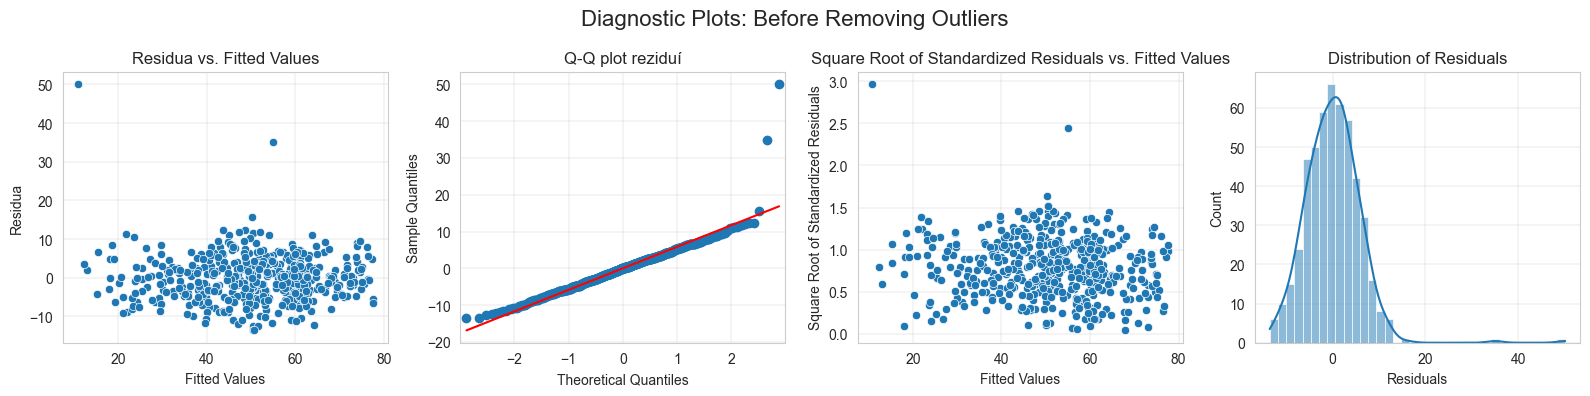

In [85]:
plot_diagnostic_subplots(model, title='Diagnostic Plots: Before Removing Outliers')

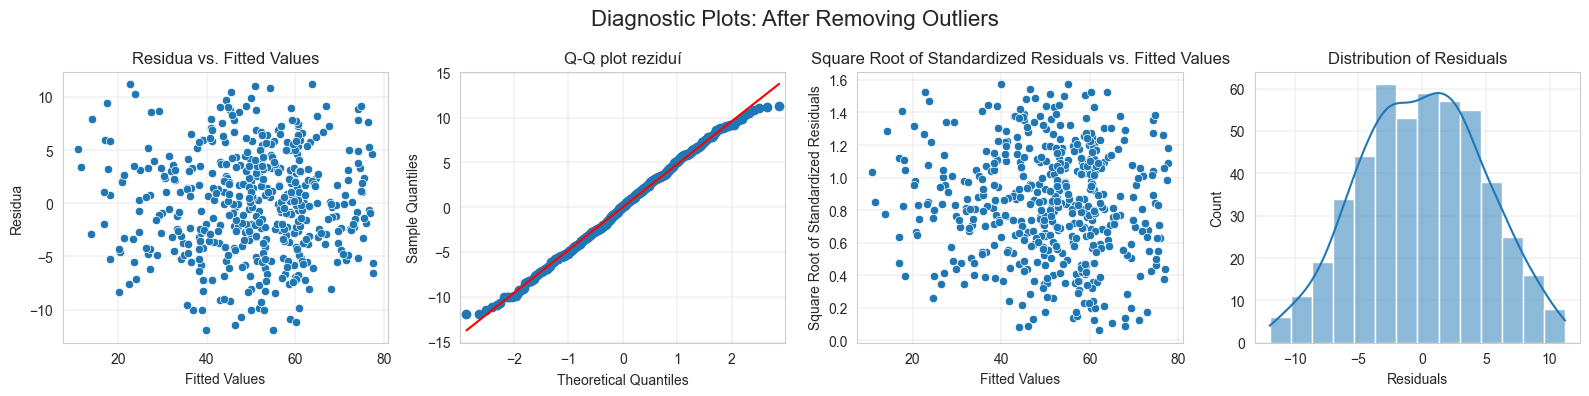

In [86]:
plot_diagnostic_subplots(model_without_outliers, title='Diagnostic Plots: After Removing Outliers')

## TASK 2.2. - Using your resulting model, identify for which parameter settings the response has the most problematic value. [1. points] 

In [87]:
# Find max ping value
max_ping = model_without_outliers.predict().argmax()
print(f"Highes ping value: {y[max_ping]:.5f}, index: {max_ping}")
print(f"For parameters: \n{poly_X.iloc[max_ping]}")

Highes ping value: 72.00000, index: 10
For parameters: 
const                         1.000000
ActiveUsers                   1.636436
InteractingPct                1.636444
iOS                           0.000000
MacOS                         1.000000
Android                       0.000000
ActiveUsers^2                 2.677922
ActiveUsers InteractingPct    2.677935
ActiveUsers MacOS             1.636436
ActiveUsers Android           0.000000
Name: 10, dtype: float64


## TASK 2.3 - Estimate the response value of a Windows user, averaging the other parameters, and calculate the confidence interval and prediction interval for this setting. [Points 1]

In [88]:
# Average values
mean_poly_X = poly_X.mean()

# Predict ping for user with Windows
predicted_ping = model_without_outliers.predict(mean_poly_X)
print(f"Predicted ping: {predicted_ping.values[0]:.5f}")

# Calculate confidence interval
confidence_interval = model_without_outliers.get_prediction(mean_poly_X).conf_int()

# Calculate prediction interval
prediction_interval = model_without_outliers.get_prediction(mean_poly_X).conf_int(obs=True)

# Print confidence and prediction interval
print(f"Confidenční interval: ({confidence_interval[0][0]:.5f}, {confidence_interval[0][1]:.5f})")
print(f"Predikční interval: ({prediction_interval[0][0]:.5f}, {prediction_interval[0][1]:.5f})")

Predicted ping: 50.61317
Confidenční interval: (50.18134, 51.04499)
Predikční interval: (41.08361, 60.14272)


## TASK 2.4. - Based on any calculated characteristics, argue whether your model is "suitable" for further use. [2. points]

### Predicted Ping and Intervals:

The model predicts a ping of approximately $50.446$ ms, with a confidence interval of (49.98837, 50.90363) and a prediction interval of (40.20294, 60.68906).

### Highest Ping Value and Corresponding Parameters:

The highest ping value observed is $72.000$ ms at index $10$. The parameter values for this extreme point are as follows:
- const: 1.000000
- ActiveUsers: 1.636436
- InteractingPct: 1.636444
- iOS: 0.000000
- MacOS: 1.000000
- Android: 0.000000
- ActiveUsers^2: 2.677922
- ActiveUsers InteractingPct: 2.677935
- ActiveUsers MacOS: 1.636436
- ActiveUsers Android: 0.000000

### Overall Model Statistics:

The Ordinary Least Squares (OLS) regression model yields the following statistics:

- **R-squared:** 0.877
- **Adjusted R-squared:** 0.875
- **F-statistic:** 388.1
- **Prob (F-statistic):** 1.43e-216
- **Log-Likelihood:** -1529.5
- **Number of Observations:** 500

### Coefficients and Significance:

- The coefficients for each predictor variable are statistically significant (P-values < 0.05).
- The model explains approximately 87.7% of the variance in the dependent variable.

### Diagnostics:

- **Omnibus Test:** The model does not violate the assumption of normality (Prob(Omnibus): 0.671).
- **Durbin-Watson Test:** The test statistic is 1.981, indicating minimal autocorrelation.
- **Jarque-Bera (JB):** The skewness and kurtosis are close to normal (Prob(JB): 0.649).

### Conclusion:

The model demonstrates strong predictive power, with high R-squared values and significant predictor coefficients. Diagnostics suggest that the model meets key assumptions, making it suitable for further use. However, thorough validation and external testing are recommended to ensure robustness across different datasets and conditions.